In [59]:
import numpy as np
import pandas as pd
import networkx as nx

In [60]:
herb_edges = pd.read_csv("../data/datahh.csv", index_col=0, dtype="Int64")
symptom_edges = pd.read_csv("../data/datass.csv", index_col=0, dtype="Int64")
protein_edges = pd.read_csv("../data/datatt.csv", index_col=0, dtype="Int64")
herb_to_symptom = pd.read_csv("../data/datahs.csv", index_col=0, dtype="Int64")
herb_to_protein = pd.read_csv("../data/dataht.csv", index_col=0, dtype="Int64")

In [61]:
herb_edges["herb1"] = 'H' + herb_edges["herb1"].astype(str)
herb_edges["herb2"] = 'H' + herb_edges["herb2"].astype(str)

symptom_edges["sym1"] = 'S' + symptom_edges["sym1"].astype(str)
symptom_edges["sym2"] = 'S' + symptom_edges["sym2"].astype(str)

protein_edges["target1"] = 'T' + protein_edges["target1"].astype(str)
protein_edges["target2"] = 'T' + protein_edges["target2"].astype(str)

herb_to_symptom["Herb_ID"] = 'H' + herb_to_symptom["Herb_ID"].astype(str)
herb_to_symptom["symptom"] = 'S' + herb_to_symptom["symptom"].astype(str)

herb_to_protein["Herb"] = 'H' + herb_to_protein["Herb"].astype(str)
herb_to_protein["target"] = 'P' + herb_to_protein["target"].astype(str)

In [62]:
herb_to_protein

,target,Herb
0,P8805,H1
1,P8766,H1
2,P8758,H1
3,P8651,H1
4,P9013,H1
...,...,...
168792,P8758,H1244
168793,P9221,H1244
168794,P9544,H1244
168795,P10692,H1244


In [63]:
#Create separate graphs for each layer
herb_graph = nx.from_pandas_edgelist(herb_edges, 'herb1', 'herb2')
symptom_graph = nx.from_pandas_edgelist(symptom_edges, 'sym1', 'sym2')
protein_graph = nx.from_pandas_edgelist(protein_edges, 'target1', 'target2')
herb_to_symptom_graph = nx.from_pandas_edgelist(herb_to_symptom, 'Herb_ID', 'symptom')
herb_to_protein_graph = nx.from_pandas_edgelist(herb_to_protein, 'Herb', 'target')

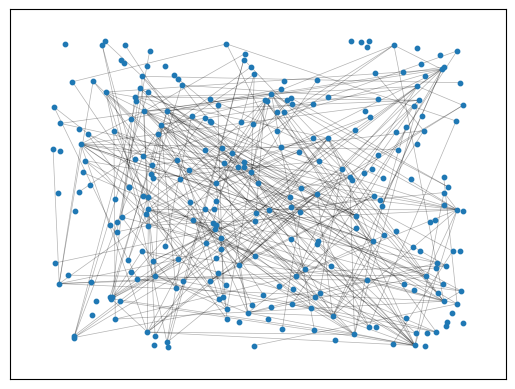

In [64]:
import networkx as nx
import matplotlib.pyplot as plt

def plot_layer_graph(layer_graph):
    pos = nx.random_layout(layer_graph)

    # Draw a subset of edges
    subset_edges = np.array(layer_graph.edges())
    np.random.shuffle(subset_edges)
    subset_edges = subset_edges[:300]

    nx.draw_networkx_nodes(layer_graph, pos, node_size=10, alpha=1,)
    nx.draw_networkx_edges(layer_graph, pos, edgelist=subset_edges, width=0.5, alpha=0.3)

    plt.show()

plot_layer_graph(herb_graph)

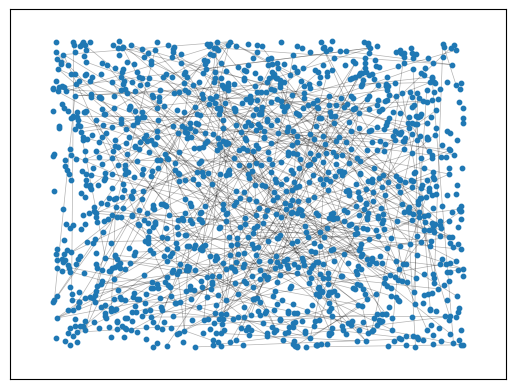

In [65]:
plot_layer_graph(herb_to_symptom_graph)

In [66]:
multi_layer_graph = nx.Graph()
graph = multi_layer_graph

# Add nodes from each layer
multi_layer_graph.add_nodes_from(herb_graph.nodes, layer='herb')
multi_layer_graph.add_nodes_from(protein_graph.nodes, layer='protein')
multi_layer_graph.add_nodes_from(symptom_graph.nodes, layer='symptom')

# Add edges from each layer
multi_layer_graph.add_edges_from(herb_graph.edges,layer='herb')
multi_layer_graph.add_edges_from(protein_graph.edges, layer='protein')
multi_layer_graph.add_edges_from(symptom_graph.edges, layer="symptom")

# Add edges between layers
multi_layer_graph.add_edges_from(herb_to_protein_graph.edges, layer= "herb_to_protein")
multi_layer_graph.add_edges_from(herb_to_symptom_graph.edges, layer="herb_to_symptom");

In [36]:
symptom_nodes = [node for node, layer in graph.nodes(data="layer") if layer == "symptom"]

# Calculate degree centrality for symptom nodes
degrees = dict(graph.degree(symptom_nodes))

# Calculate betweenness centrality for symptom nodes
betweenness_centrality = nx.betweenness_centrality(graph.subgraph(symptom_nodes))

In [56]:
degree_threshold = 30
centrality_threshold = .00000001

useless_by_degree = [node for node, degree in degrees.items() if degree <= degree_threshold]

useless_by_betweenness = [node for node, centrality in betweenness_centrality.items() if centrality <= centrality_threshold]

useless_symptoms = set(useless_by_degree) & set(useless_by_betweenness)

# Remove useless symptom nodes from the graph
graph.remove_nodes_from(useless_symptoms)

len(symptom_nodes) , len(useless_by_degree), len(useless_by_betweenness), len(useless_symptoms),len(useless_symptoms)/len(symptom_nodes)

(680, 284, 223, 213, 0.31323529411764706)

In [57]:
symptom_nodes = [node for node, layer in graph.nodes(data="layer") if layer == "symptom"]
len(symptom_nodes)

467

In [73]:
from local_similarity_indices import features, calc_local_similarity

g = multi_layer_graph
# Calculate average neighbors for the entire g
avg_neighbors = sum(deg for _, deg in g.degree() for node in g) / len(g)  

In [58]:
#block for layer:
nbfl = 0
bfl = [["herb_to_protein", "ht_result"], ["herb_to_symptom", "hs_result"]]

from local_similarity_indices import features, calc_local_similarity

results_dict = {}

for node1, node2, layer in multi_layer_graph.edges(data="layer"):
    if layer == bfl[nbfl][0]:
        r = calc_local_similarity(multi_layer_graph, node1, node2, avg_neighbors)
        
        result_entry = {}
        for i, f in enumerate(features):
            result_entry[f"{f.__name__}"] = f(**r)
        
        results_dict[f"{node1}, {node2}"] = result_entry

pd.DataFrame.from_dict(results_dict).transpose().to_csv(f"{bfl[nbfl][1]}.csv")

{'H1244, P8758': {'calc_CN': 12, 'calc_JC': 0.014723926380368098, 'calc_SL': 0.03013686848373063, 'calc_SI': 0.014510278113663845, 'calc_PA': 158550, 'calc_AA': 2.1586966449132943, 'calc_RA': 0.04990192520930519, 'calc_HP': 0.039735099337748346, 'calc_HD': 0.022857142857142857, 'calc_LHN': 7.568590350047304e-05, 'calc_PD': 4.773629990569097e-10, 'calc_LAS': 0.0625922421948912, 'calc_CB': 21660.0, 'calc_IA': 0.5108066665538717, 'calc_MI': 88.8293226255836, 'calc_FSW': 2.7938043794742304e-09, 'calc_LNL': 6.462211829094483}}


In [89]:
# Copy results to ../result_data to read.
ht_result = pd.read_csv("../result_data/ht_result.csv",index_col=0)
hs_result = pd.read_csv("../result_data/hs_result.csv",index_col=0)

In [90]:
ht_result

,ht,CN,JC,SL,SI,PA,AA,RA,HP,HD,LHN,PD,LAS,CB,IA,MI,FSW,LNL,KI,GLHN
0,"H1244, P8758",0.324324,0.173006,0.183625,0.185006,0.120514,0.304497,0.099804,0.059603,0.188571,0.006358,0.000003,0.091595,0.124290,0.154855,0.345934,0.105221,0.291129,-0.296088,0.001905
1,"H1244, P8651",0.270270,0.187700,0.191848,0.200472,0.076670,0.264556,0.113525,0.049669,0.247006,0.008328,0.000007,0.092268,0.080364,0.189288,0.305400,0.073072,0.250182,-0.043704,0.002994
2,"H1244, P8781",0.405405,0.194967,0.211728,0.208107,0.141633,0.378732,0.118178,0.074503,0.200567,0.006762,0.000003,0.108259,0.190997,0.191968,0.418658,0.164402,0.383026,0.388417,0.001621
3,"H1244, P9066",0.297297,0.175850,0.183034,0.188003,0.101920,0.269268,0.071581,0.054636,0.204392,0.006891,0.000004,0.089555,0.117783,0.094569,0.311747,0.088416,0.261477,0.347054,0.002252
4,"H1244, P9282",0.459459,0.201564,0.224324,0.215030,0.162063,0.439719,0.158021,0.084437,0.198654,0.006698,0.000003,0.117611,0.226852,0.297796,0.477853,0.211160,0.450455,-0.065317,0.001416
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
166789,"P9080, H1149",0.000000,0.000000,0.000000,0.000000,0.000015,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.050772,0.000000,0.000000,-0.139342,1.000000
166790,"P9080, H1206",0.000000,0.000000,0.000000,0.000000,0.000159,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.050772,0.000000,0.000000,0.088148,0.100000
166791,"P10977, H687",0.000000,0.000000,0.000000,0.000000,0.001170,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.050772,0.000000,0.000000,-0.135084,0.012987
166792,"H241, P9498",0.000000,0.000000,0.000000,0.000000,0.000002,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.050772,0.000000,0.000000,2.195273,0.333333


In [69]:
col = [str(x).replace("calc_","") for x in ht_result.columns]
col[0] = "ht"
ht_result.columns = col

col = [str(x).replace("calc_","") for x in hs_result.columns]
col[0] = "hs"
hs_result.columns = col

In [70]:
hs_result.describe()

,CN,JC,SL,SI,PA,AA,RA,HP,HD,LHN,PD,LAS,CB,IA,MI,FSW,LNL
count,15217.000000,15217.000000,15217.000000,15217.000000,15217.000000,15217.000000,15217.000000,15217.000000,15217.000000,15217.000000,1.521700e+04,15217.000000,1.521700e+04,15217.000000,15217.000000,1.521700e+04,15217.000000
mean,23.791023,0.076855,0.158743,0.068264,43737.223040,4.613722,0.175452,0.283504,0.102180,0.001583,4.821092e-07,0.385684,1.191842e+05,4.440855,156.412387,1.680881e-08,19.244419
std,16.694752,0.064329,0.108686,0.052185,67085.348256,3.315677,0.147233,0.201846,0.088608,0.002054,2.254090e-06,0.254323,1.280357e+05,4.948800,148.237499,2.117541e-08,18.721823
min,0.000000,0.000000,0.000000,0.000000,16.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,-24.857293,0.000000e+00,0.000000
25%,12.000000,0.031019,0.078296,0.030086,6432.000000,2.237382,0.071406,0.125000,0.038095,0.000343,5.061895e-09,0.182346,1.714800e+04,0.845664,39.143650,2.866646e-09,4.744557
50%,21.000000,0.059406,0.144382,0.056075,18744.000000,4.034760,0.144820,0.257669,0.077181,0.000882,3.430035e-08,0.360796,8.088000e+04,2.707760,120.038084,8.778047e-09,13.686559
75%,35.000000,0.112219,0.228182,0.100897,49364.000000,6.675229,0.249596,0.411765,0.149606,0.002051,2.035101e-07,0.561404,1.735580e+05,6.410003,235.205988,2.437890e-08,28.742104
max,115.000000,0.432432,0.606478,0.301887,508008.000000,25.062721,1.474233,0.925926,0.589744,0.022989,1.291322e-04,1.218391,1.150518e+06,43.036724,1027.438876,2.629110e-07,146.795981


In [91]:
from sklearn.discriminant_analysis import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler

num_pipeline = make_pipeline(
    MinMaxScaler(),
    )

cat_pipeline = make_pipeline("passthrough")

from sklearn.compose import make_column_selector, make_column_transformer

preprocessing = make_column_transformer(
    ("passthrough", make_column_selector(dtype_include=object)),
    (num_pipeline ,make_column_selector(dtype_include=np.number)),
)

htr = preprocessing.fit_transform(ht_result)
hsr = preprocessing.fit_transform(hs_result)


In [92]:
pd.DataFrame(htr, columns=ht_result.columns).to_csv("ht_result.csv")
pd.DataFrame(hsr, columns=hs_result.columns).to_csv("hs_result.csv")


In [ ]:
# 183359  -- sym = 16565, target = 166794

In [13]:
import random

num_subgraphs = 1  
subgraph_size = 500  

random_nodes = random.sample(list(multi_layer_graph.nodes()), num_subgraphs * subgraph_size)

# Create a subgraph from the selected nodes
subgraph = multi_layer_graph.subgraph(random_nodes)